In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy



def evaluate_model_2(model, images_test, labels_test, batch_size=16, num_steps=10):
    
    total_samples = len(images_test) 
    step_size = total_samples // num_steps  # Size of each step
    auc_per_class = [0] * NUMBER_CLASSES
    
    for step in range(num_steps):
        start_idx = step * step_size
        end_idx = min((step + 1) * step_size, total_samples)
        
        images_batch = images_test[start_idx:end_idx]
        labels_batch = labels_test[start_idx:end_idx]
        
        # images_batch_2 = tf.cast(images_batch, np.float32) / 255.0
        
        images_batch_2 = []
        for sample in images_batch:
            images_batch_2.append(normalize_image(sample, None)) 
        images_batch_2 = np.array([tensor[0].numpy() for tensor in images_batch_2])

        predictions_batch = model.predict(images_batch_2, batch_size=batch_size)
        
        for class_idx in range(NUMBER_CLASSES):
            true_labels_class = labels_batch[:, class_idx]
            
            auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions_batch[:, class_idx])
            print(auc)
            auc_per_class[class_idx] += auc
            
    auc_per_class = [auc / num_steps for auc in auc_per_class]
    
    return auc_per_class, 0, 0

In [6]:
# Resolution for multiple runs

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

# for ev_image_size in [100, 200, 224, 300, 400, 500, 768, 1024]:
# for ev_image_size in [32]:
for ev_image_size in [448]:
    
    evals_per_size = []

    for i in range(5):     
        
        tf.keras.backend.clear_session()
        
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        model = create_resnet_model(ev_image_size) #MAKE PREPARE DATA NORMAL
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                
        history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=1)
        
        evals = evaluate_model_2(model, images_test, labels_test, num_steps=10)
        evals_per_size.append(evals)
        print(evals_per_size)
        
    evaluations[ev_image_size] = evals_per_size
    print(f'\n{evals_per_size}\n')
    
# with open(f"pickles/rework/res_10000samples_20epochs_ES.pkl", "wb") as file:
#     pickle.dump(evaluations, file)
    
print(evaluations)

100%|██████████| 2000/2000 [00:40<00:00, 49.93it/s]
2025-03-27 09:28:08.040443: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-27 09:28:08.043225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-27 09:28:08.043712: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-27 09:28:08.044512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 09:28:08.045423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-03-27 09:28:46.809830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


500/500 ━━━━━━━━━━━━━━━━━━━━ 276s 542ms/step - auc: 0.6267 - loss: 1.4560 - val_auc: 0.7287 - val_loss: 0.8681
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 267s 533ms/step - auc: 0.7392 - loss: 0.8444 - val_auc: 0.7341 - val_loss: 0.8671
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 269s 537ms/step - auc: 0.7720 - loss: 0.8062 - val_auc: 0.7356 - val_loss: 0.8600
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 244s 488ms/step - auc: 0.8069 - loss: 0.7562 - val_auc: 0.7222 - val_loss: 0.9573
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 251s 501ms/step - auc: 0.8445 - loss: 0.6962 - val_auc: 0.7176 - val_loss: 0.8971
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4034s 8s/step - auc: 0.8823 - loss: 0.6111 - val_auc: 0.7007 - val_loss: 0.9896
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 482ms/step
0.6870199692780338
0.8514102936900261
0.6730292040465737
0.7534466911764706
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step
0.7762237762237763
0.8919413919413919
0.6852159468438539
0.7832672196177425
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step
0.7811

100%|██████████| 2000/2000 [00:39<00:00, 51.00it/s]


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2085s 4s/step - auc: 0.6271 - loss: 1.3231 - val_auc: 0.7346 - val_loss: 0.8893
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3962s 8s/step - auc: 0.7330 - loss: 0.8377 - val_auc: 0.7450 - val_loss: 0.8689
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 244s 488ms/step - auc: 0.7706 - loss: 0.7960 - val_auc: 0.7461 - val_loss: 0.8347
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 235s 471ms/step - auc: 0.8034 - loss: 0.7522 - val_auc: 0.7386 - val_loss: 0.8617
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 240s 481ms/step - auc: 0.8386 - loss: 0.6962 - val_auc: 0.7214 - val_loss: 0.9086
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 238s 477ms/step - auc: 0.8829 - loss: 0.6082 - val_auc: 0.7189 - val_loss: 0.9047
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step
0.7030213706705969
0.8493693693693694
0.7803768680961665
0.6964134125636674
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step
0.7112135176651306
0.8453014184397163
0.703921568627451
0.6762152777777778
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/st

 24%|██▍       | 483/2000 [00:13<00:43, 34.78it/s]


KeyboardInterrupt: 

In [4]:
evaluations = {}
evaluations[32] = [([0.638252688172043, 0.6873473533417876, 0.6146112514351321, 0.6572111356300825], 0.26264254565823064, 0.6685),
                   ([0.6261541242560765, 0.7133933423913044, 0.5783888405661666, 0.653745868945869], 0.26340978832932427, 0.664),
                   ([0.6135198238536449, 0.7098456780293783, 0.5978607011666942, 0.6480525498924663], 0.26034635907696063, 0.682),
                   ([0.7033855687495945, 0.671432643639802, 0.5885196078431373, 0.6373227052860804], 0.26289179658868045, 0.698),
                   ([0.5744437215354588, 0.7362918771369478, 0.6009966688158177, 0.6449853409197079], 0.2518191607387587, 0.691)]
evaluations[112] = [([0.6661935990904894, 0.7638733526197363, 0.614283262739959, 0.6930551814742111], 0.27399976238818413, 0.692),
                    ([0.7134413190342664, 0.7811979674144969, 0.6268509851921185, 0.7240986704053778], 0.2745453550179048, 0.6855),
                    ([0.6950589422535259, 0.7956345251541584, 0.6276806822019587, 0.7037122708169342], 0.25285388979544987, 0.6815),
                    ([0.7112448642338423, 0.7513740611780955, 0.6383579012296323, 0.7164300089445439], 0.285962474358083, 0.679),
                    ([0.6929941312909603, 0.7757518996758596, 0.6549929880555152, 0.7125424723050413], 0.30249432531366494, 0.692)]
evaluations[224] = [([0.6716880846227818, 0.8284134018144874, 0.6682502430428972, 0.7004768883775294], 0.29935427495722866, 0.6775),
                    ([0.7115062505463764, 0.8138981104911629, 0.638248421889756, 0.7315003142946777], 0.2513812154696133, 0.685),
                    ([0.6845355217481724, 0.8150976648553385, 0.6593881889275074, 0.711111434563382], 0.26557221720547913, 0.7125),
                    ([0.7250451037765884, 0.8073949077238551, 0.6594167623421354, 0.7129073427861854], 0.3206725638875778, 0.6955),
                    ([0.6996336384676269, 0.7755279279279279, 0.6505182091399275, 0.7059342502168202], 0.3111942157368912, 0.6725)]
evaluations[336] = [([0.6661534644795984, 0.8075352399368989, 0.6864057274739768, 0.7180456289117707], 0.3044396364163806, 0.6895),
                    ([0.7099277484387699, 0.8108072507675317, 0.6250691159586682, 0.7003952837828178], 0.2895519997623176, 0.681),
                    ([0.7377188940092166, 0.8201898817545317, 0.6962327630776828, 0.7301747617825537], 0.3220176512816182, 0.6915),
                    ([0.7428229665071769, 0.8086812883711273, 0.7030551347984444, 0.7509132676717295], 0.29289407535742423, 0.6995),
                    ([0.6982655502392345, 0.8125516560986048, 0.6744251673006868, 0.7242850195943821], 0.3353663962230159, 0.6845)]
evaluations[448] = [([0.785575898689229, 0.8443756400153382, 0.6750081425258291, 0.7473763221888254], 0, 0),
                    ([0.7559210337640034, 0.8153996707777935, 0.6832379470431237, 0.7415045740149417], 0, 0),
                    ([0.7037160547890824, 0.8181740038339868, 0.7024138725174133, 0.7005163515705802], 0, 0),
                    ([0.7435659210941655, 0.833218794058164, 0.6879334289695478, 0.7467933224646066], 0, 0),
                    ([0.7132594176645719, 0.821967508294381, 0.6958066273630255, 0.7031234544458448], 0, 0)]

[0.04199954634878846, 0.016939422111838943, 0.018915464637055384, 0.027932510434109277, 0.02957739041844152]
[0.022372057962981553, 0.01507630225054882, 0.017644552032960868, 0.004466274787869154, 0.010748794349361745]
[0.012172825104813444, 0.013617737638015395, 0.01014790295050816, 0.027715253392659817, 0.009553021092945825]
[0.006936978715565216, 0.010707370275306128, 0.010494811491392019, 0.016445429747652524, 0.021378043350232922]


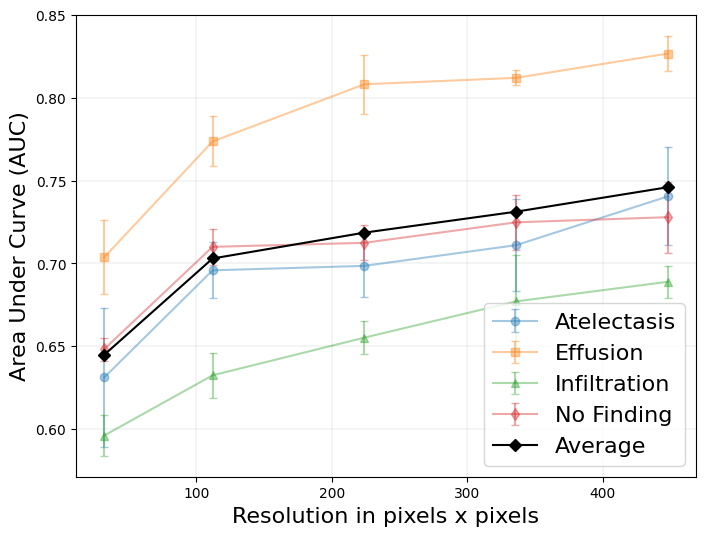

In [7]:
aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []
aucs_All_means = []
aucs_All_stds = []


for evals_per_size in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_size:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))

x_values = list(evaluations.keys())

alpha = 0.4
plt.figure(figsize=(8, 6))

print(aucs_at_stds)
print(aucs_ef_stds)
print(aucs_in_stds)
print(aucs_nf_stds)



font_size=16

plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-s', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-^', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-d', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_All_means, label='Average', marker='D', color='black')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="best")

plt.savefig("evalsNewNew/resolution_10000samples_20epochs_5runs.pdf", bbox_inches='tight', pad_inches=0)


plt.show()